In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns

In [2]:
df = pd.read_csv('merge_data.csv')

In [3]:
df.isnull().sum()

Unnamed: 0                  0
order_id                    0
date                        0
payment                     0
item_code                   0
quantity                    0
unit_price_vat_excl         0
unit_cogs                   0
unit_rrp_vat_excl           0
department                  0
channel                     0
owner                       0
site                        0
CreatedAt                   0
store_ca                    0
location                   46
country                    46
days_of_week                0
month                       0
days                        0
sales                       0
item_name              839482
style                  839482
brand_id               839482
name                   839482
group0_id              839482
group0                 839482
group1_id              839482
group1                 839482
group2_id              839482
category               839482
gender                 839482
age                    839482
color     

In [8]:
df_country_product=df[((df['country'] == "Czech Republic") & (df['category'] == "football"))]

In [12]:
df_country_product.quantity.sum()

247908

In [13]:
df_country_product.country.value_counts()

Czech Republic    226743
Name: country, dtype: int64

In [14]:
df_country_product.category.value_counts()

football    226743
Name: category, dtype: int64

In [17]:
df_country_product_features=df_country_product.sort_values('date').groupby(['date','country', 'unit_price_vat_excl', 'unit_cogs'], as_index=False)
df_country_product_features=df_country_product_features.agg({'quantity':['sum'], 'sales':['sum']})
df_country_product_features.columns=['date', 'country', 'unit_price_vat_excl', 'unit_cogs', 'quantity', 'sales']
df_country_product_features.head()

,date,country,unit_price_vat_excl,unit_cogs,quantity,sales
0,2019-06-01,Czech Republic,4.997287,2.807364,1,4.997287
1,2019-06-01,Czech Republic,5.605814,3.649225,1,5.605814
2,2019-06-01,Czech Republic,6.630620,0.070930,2,13.261240
3,2019-06-01,Czech Republic,6.630620,2.503101,5,33.153101
4,2019-06-01,Czech Republic,9.353488,5.406589,1,9.353488


In [18]:
df_country_product_features['cost']=df_country_product_features['unit_cogs']*df_country_product_features['quantity']
df_country_product_features['profit']=df_country_product_features['sales']-df_country_product_features['cost']

/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_36656/2480107293.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_country_product_features.corr()))
/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_36656/2480107293.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sb.heatmap(df_country_product_features.corr(), cmap="YlGnBu", annot=True, mask=mask)


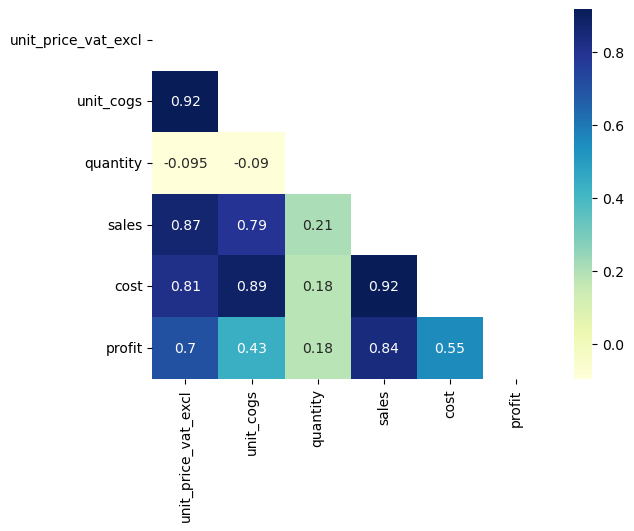

In [20]:
mask = np.triu(np.ones_like(df_country_product_features.corr()))
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(df_country_product_features.corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
mp.show()

In [22]:
df_f= df_country_product_features[['date', 'quantity', 'sales', 'cost', 'profit']]
df_final = df_f.groupby(['date']).sum()

In [23]:
#LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler

2022-12-05 14:37:13.096638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
df_final.reset_index(inplace=True)
df_final

,date,quantity,sales,cost,profit
0,2019-06-01,45,1636.585269,974.832558,661.752711
1,2019-06-03,9,581.139922,386.106589,195.033333
2,2019-06-04,256,10669.917816,5797.353101,4872.564715
3,2019-06-05,676,23662.911977,4566.316279,19096.595698
4,2019-06-06,136,5414.245729,2106.836047,3307.409683
...,...,...,...,...,...
949,2022-01-10,332,10895.796107,6585.142636,4310.653471
950,2022-01-11,310,11705.391071,7029.982558,4675.408513
951,2022-01-12,288,9861.969752,5804.209302,4057.760450
952,2022-01-13,264,9803.992235,5974.120155,3829.872080


In [25]:
train_dates=pd.to_datetime(df_final['date'])
train_dates

0     2019-06-01
1     2019-06-03
2     2019-06-04
3     2019-06-05
4     2019-06-06
         ...    
949   2022-01-10
950   2022-01-11
951   2022-01-12
952   2022-01-13
953   2022-01-14
Name: date, Length: 954, dtype: datetime64[ns]

In [26]:
cols=list(df_final)[1:5]
cols

['quantity', 'sales', 'cost', 'profit']

In [27]:
df_for_training=df_final[cols].astype(float)

<AxesSubplot:>

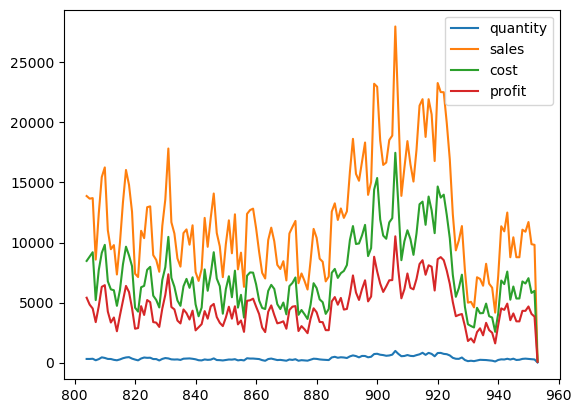

In [28]:
df_for_plot=df_for_training.tail(150)
df_for_plot.plot.line()

In [29]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [30]:
trainX = []
trainY = []

n_feature=1
n_past=14

for i in range(n_past, len(df_for_training_scaled)-n_feature+1):
    trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_feature-1:i+n_feature, 0])

trainX, trainY=np.array(trainX), np.array(trainY)

print('trainX shape=={}'.format(trainX.shape))
print('trainY shape=={}'.format(trainY.shape))

trainX shape==(940, 14, 4)
trainY shape==(940, 1)


In [31]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary

history = model.fit(trainX, trainY, epochs=200, batch_size=16, validation_split=0.1, verbose=1)

2022-12-05 14:39:07.814996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
53/53 [==============================] - 4s 21ms/step - loss: 0.4963 - val_loss: 0.9539
Epoch 2/200
53/53 [==============================] - 1s 16ms/step - loss: 0.3807 - val_loss: 0.7416
Epoch 3/200
53/53 [==============================] - 1s 23ms/step - loss: 0.3317 - val_loss: 0.5617
Epoch 4/200
53/53 [==============================] - 1s 17ms/step - loss: 0.3224 - val_loss: 0.5623
Epoch 5/200
53/53 [==============================] - 1s 18ms/step - loss: 0.2750 - val_loss: 0.6027
Epoch 6/200
53/53 [==============================] - 1s 16ms/step - loss: 0.2729 - val_loss: 0.5510
Epoch 7/200
53/53 [==============================] - 1s 16ms/step - loss: 0.2815 - val_loss: 0.4571
Epoch 8/200
53/53 [==============================] - 1s 12ms/step - loss: 0.2761 - val_loss: 0.5345
Epoch 9/200
53/53 [==============================] - 1s 14ms/step - loss: 0.2605 - val_loss: 0.4921
Epoch 10/200
53/53 [==============================] - 1s 22ms/step - loss: 0.2515 - val_loss: 0.4380

53/53 [==============================] - 1s 13ms/step - loss: 0.1272 - val_loss: 0.3500
Epoch 83/200
53/53 [==============================] - 1s 14ms/step - loss: 0.1263 - val_loss: 0.4212
Epoch 84/200
53/53 [==============================] - 1s 13ms/step - loss: 0.1397 - val_loss: 0.3976
Epoch 85/200
53/53 [==============================] - 1s 12ms/step - loss: 0.1263 - val_loss: 0.3541
Epoch 86/200
53/53 [==============================] - 1s 13ms/step - loss: 0.1352 - val_loss: 0.3488
Epoch 87/200
53/53 [==============================] - 1s 14ms/step - loss: 0.1270 - val_loss: 0.4166
Epoch 88/200
53/53 [==============================] - 1s 12ms/step - loss: 0.1308 - val_loss: 0.3838
Epoch 89/200
53/53 [==============================] - 1s 13ms/step - loss: 0.1238 - val_loss: 0.3872
Epoch 90/200
53/53 [==============================] - 1s 13ms/step - loss: 0.1333 - val_loss: 0.4025
Epoch 91/200
53/53 [==============================] - 1s 13ms/step - loss: 0.1275 - val_loss: 0.3828
Epo

53/53 [==============================] - 1s 15ms/step - loss: 0.0912 - val_loss: 0.4860
Epoch 163/200
53/53 [==============================] - 1s 15ms/step - loss: 0.0794 - val_loss: 0.4960
Epoch 164/200
53/53 [==============================] - 1s 14ms/step - loss: 0.0771 - val_loss: 0.4723
Epoch 165/200
53/53 [==============================] - 1s 14ms/step - loss: 0.0792 - val_loss: 0.4666
Epoch 166/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0810 - val_loss: 0.5179
Epoch 167/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0706 - val_loss: 0.5382
Epoch 168/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0739 - val_loss: 0.4977
Epoch 169/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0780 - val_loss: 0.4576
Epoch 170/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0733 - val_loss: 0.4803
Epoch 171/200
53/53 [==============================] - 1s 13ms/step - loss: 0.0772 - val_loss: 0

In [32]:
n_future=365
forecast_period_dates=pd.date_range(list(train_dates)[-1], periods=n_future, freq='D').tolist()

forecast = model.predict(trainX[-n_future:])
forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'quantity':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

original = df_final[['date', 'quantity']]
original['date']=pd.to_datetime(original['date'])

12/12 [==============================] - 1s 7ms/step


/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_36656/414224598.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='quantity'>

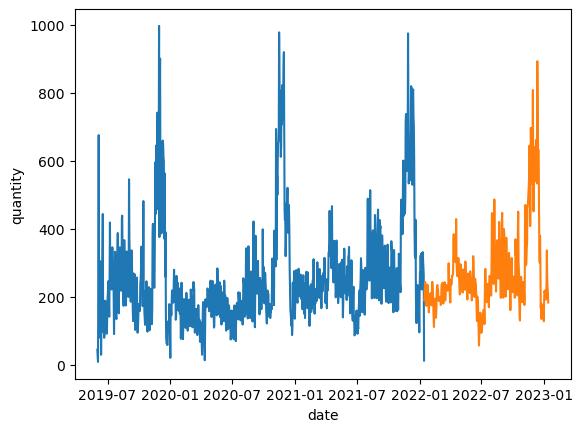

In [33]:
sns.lineplot(original['date'], original['quantity'])
sns.lineplot(df_forecast['date'], df_forecast['quantity'])

In [34]:
df_forecast.round(0)

,date,quantity
0,2022-01-14,191.0
1,2022-01-15,192.0
2,2022-01-16,224.0
3,2022-01-17,244.0
4,2022-01-18,240.0
...,...,...
360,2023-01-09,337.0
361,2023-01-10,256.0
362,2023-01-11,228.0
363,2023-01-12,213.0


In [35]:
#CNN 
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten

Epoch 1/200
53/53 [==============================] - 3s 10ms/step - loss: 0.4016 - val_loss: 0.7168
Epoch 2/200
53/53 [==============================] - 0s 5ms/step - loss: 0.2538 - val_loss: 1.1039
Epoch 3/200
53/53 [==============================] - 0s 6ms/step - loss: 0.2116 - val_loss: 0.6186
Epoch 4/200
53/53 [==============================] - 0s 5ms/step - loss: 0.2013 - val_loss: 0.5771
Epoch 5/200
53/53 [==============================] - 0s 5ms/step - loss: 0.1844 - val_loss: 0.6384
Epoch 6/200
53/53 [==============================] - 0s 5ms/step - loss: 0.1736 - val_loss: 0.6993
Epoch 7/200
53/53 [==============================] - 0s 5ms/step - loss: 0.1660 - val_loss: 0.5990
Epoch 8/200
53/53 [==============================] - 0s 5ms/step - loss: 0.1601 - val_loss: 0.6426
Epoch 9/200
53/53 [==============================] - 0s 5ms/step - loss: 0.1549 - val_loss: 0.6601
Epoch 10/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1496 - val_loss: 0.5793
Epoch 11

53/53 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.8385
Epoch 84/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0186 - val_loss: 0.8496
Epoch 85/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0169 - val_loss: 0.7820
Epoch 86/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.9098
Epoch 87/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0184 - val_loss: 0.9649
Epoch 88/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.8644
Epoch 89/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.8238
Epoch 90/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0205 - val_loss: 0.8910
Epoch 91/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.9261
Epoch 92/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0200 - val_loss: 0.9163
Epoch 93/200


53/53 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.8567
Epoch 165/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.9442
Epoch 166/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0169 - val_loss: 0.8830
Epoch 167/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0178 - val_loss: 0.8098
Epoch 168/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.8677
Epoch 169/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.8887
Epoch 170/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.9644
Epoch 171/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.9259
Epoch 172/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.8691
Epoch 173/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.8741
Epoc

/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_36656/80498196.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explici

<AxesSubplot:xlabel='date', ylabel='quantity'>

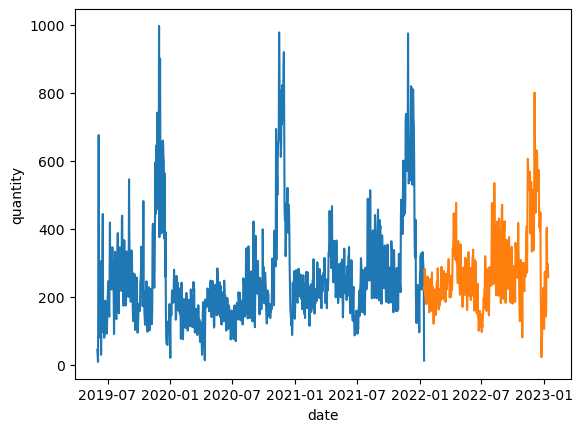

In [36]:
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.summary

history_cnn = model_cnn.fit(trainX, trainY, epochs=200, batch_size=16, validation_split=0.1, verbose=1)

n_future=365
forecast_period_dates=pd.date_range(list(train_dates)[-1], periods=n_future, freq='D').tolist()

forecast = model_cnn.predict(trainX[-n_future:])

forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'quantity':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

original = df_final[['date', 'quantity']]
original['date']=pd.to_datetime(original['date'])

sns.lineplot(original['date'], original['quantity'])
sns.lineplot(df_forecast['date'], df_forecast['quantity'])

In [37]:
df_forecast.round(0)

,date,quantity
0,2022-01-14,230.0
1,2022-01-15,221.0
2,2022-01-16,283.0
3,2022-01-17,240.0
4,2022-01-18,201.0
...,...,...
360,2023-01-09,404.0
361,2023-01-10,260.0
362,2023-01-11,270.0
363,2023-01-12,297.0
